<a href="https://colab.research.google.com/github/Val3nt-ML/Technical-Tests/blob/main/Accuracy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Airbus Accuracy Prediction**

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')
!nvcc --version
sys.path.append('/content/gdrive/My Drive/Airbus/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [ ]:
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=DeprecationWarning)
import pandas as pd
pd.set_option('display.max_columns', 45)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import preprocessing, metrics, svm
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingClassifier, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV


In [ ]:
def normalize_PN(pn):
  return(pn[0].lower()+pn[1:])


#Fichier Drivers Test
df=pd.read_excel("/content/gdrive/My Drive/Airbus/Test samples.xlsx", sheet_name=1)
df.set_index('partNumber', inplace=True)
#Références Métiers et Coûts
df_0=pd.read_excel("/content/gdrive/My Drive/Airbus/Test samples.xlsx")
#On met le partNumber en minuscule
df_0['partNumber']=df_0['partNumber'].apply(normalize_PN)
df_0.set_index('partNumber', inplace=True)

#df_0=pd.DataFrame(df_0['Total Cost/PN'])
df_0=pd.DataFrame(df_0[ 'Total Cost/PN'])

#Jointure des deux tables sur le partNumber (minuscule)
df=df.join(df_0)


#Fichier de Références
df_references=pd.read_excel("/content/gdrive/My Drive/Airbus/Reference sample.xlsx", sheet_name=1)
df_references_0=pd.read_excel("/content/gdrive/My Drive/Airbus/Reference sample.xlsx")
df_references.set_index('partNumber', inplace=True)
df_references_0.set_index('partNumber', inplace=True)

#df_references_0=pd.DataFrame(df_references_0['Total Cost/PN'])
df_references_0=pd.DataFrame(df_references_0['Total Cost/PN'])

#Jointure des deux tables sur le partNumber (minuscule)
df_references=df_references.join(df_references_0)


df['IsReference']=0
df_references['IsReference']=1


df=pd.concat([df,df_references], sort=False)
df.reset_index(drop=True, inplace=True)
df['IsReference']=df['IsReference'].astype(bool)

df.head()

In [ ]:
print(df[df['IsReference']==False].shape)
print(df[df['IsReference']==True].shape)

(4667, 38)
(746, 38)


## **Valeurs Manquantes**

In [ ]:
print("Valeurs Manquantes de DF avant processing: \n")
df.isna().sum()

Valeurs Manquantes de DF avant processing: 



costingGroup                               0
Part Category for assembly operation    4389
Designation                                1
Material Fly Weight [kg]                   1
Length                                     0
Width                                      0
Thickness                                  1
Projected Area Ratio                       1
Projected Length                           1
Projected Width                            1
Projected Height                           1
Bounding Box Length                        1
Bounding Box Width                         1
Bounding Box Height                        1
Max Diagonal Part                          1
Length of finished part                    1
Width of finished part                     1
Height of finished part                    1
Projected Perimeter                        1
Finished Part Surface                      1
DPT Wet Surface Area                       1
form                                       0
compositio

On peut tout d'abord remarquer que la colonne Part Category for assembly operation contient 3681 valeurs manquantes, soit 69% de valeurs manquantes. On peut ainsi faire raisonnablement le choix de supprimer cette variable.

***Part Category for assembly operation Variable***

In [ ]:
df.drop(columns=['Part Category for assembly operation'], inplace=True)
df.shape

(5413, 37)

***Nb of bonding point [Qty] Variable***

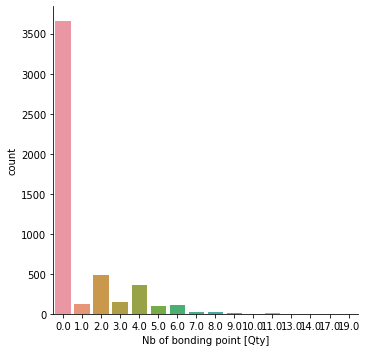

In [ ]:
sns.catplot(x='Nb of bonding point [Qty]', kind='count', data=df)

In [ ]:
Bonding_variables=['Bounding Box Length','Bounding Box Width', 'Bounding Box Height', 'Nb of bonding point [Qty]', 'Bounding Box Volume' ]
df.loc[df['Nb of bonding point [Qty]'].isna(), Bonding_variables]

In [ ]:
df['Nb of bonding point [Qty]'].fillna(value=0, inplace=True)

***Total Cost Variable***

In [ ]:
t=df_references[df_references['Total Cost/PN'].isna()]
print("Nombre de valeurs manquantes de la variable Total Cost dans les références: "+str(t.shape[0]))

Nombre de valeurs manquantes de la variable Total Cost dans les références: 8


On peut remarquer que les 8 valeurs manquantes de la variable 'Total Cost' font parties de l'ensemble de références. On peut donc faire le choix de supprimer les données correspondantes.

In [ ]:
df.drop(df[df['Total Cost/PN'].isna()].index, inplace=True)

In [ ]:
df[df['IsReference']==1].shape

(738, 37)

***Other Variables***

In [ ]:
df=pd.DataFrame(df.fillna(method='bfill', axis=1))
df.isna().sum()

costingGroup                        0
Designation                         0
Material Fly Weight [kg]            0
Length                              0
Width                               0
Thickness                           0
Projected Area Ratio                0
Projected Length                    0
Projected Width                     0
Projected Height                    0
Bounding Box Length                 0
Bounding Box Width                  0
Bounding Box Height                 0
Max Diagonal Part                   0
Length of finished part             0
Width of finished part              0
Height of finished part             0
Projected Perimeter                 0
Finished Part Surface               0
DPT Wet Surface Area                0
form                                0
composition                         0
Material density                    0
Material Cluster                    0
Buy Weight                          0
Nb of bonding point [Qty]           0
Surface prot

## **Statistiques Descriptives**

In [ ]:
#print(df.dtypes)

On peut s'apercevoir que l'ensemble des variables sont toutes du type 'object' qui est générique. Il faut donc retyper ces variables.

In [ ]:
for col in df.columns:
  try:
    df[col]=df[col].astype(float)
  except:
    print(col)
    continue
df.dtypes[:5]

In [ ]:
df.drop(df[df['Thickness']=='plate'].index, inplace=True)
df[df['IsReference']==1].shape

(738, 37)

On s'aperçoit que plusieures variables Numériques, telles que la vaiable 'Thickness', n'a pas été convertit en float. En étudiant de plus près cette variable on peut remarquer qu'une donnée du set a de multiples champs avec la valeur 'plate', que l'on peut considérer comme une erreur, et donc supprimer cette donnée.

In [ ]:
for col in df.columns:
  try:
    df[col]=df[col].astype(float)
  except:
    print(col)
    continue
df.dtypes[:5]

costingGroup
Designation
form
composition
Material Cluster
Surface protection code (DPT)


costingGroup                 object
Designation                  object
Material Fly Weight [kg]    float64
Length                      float64
Width                       float64
dtype: object

### **Variables Numériques**

In [ ]:
df.describe()

Après une analyse rapide, il ne semble pas y avoir de valeurs aberrantes au sein des variables numériques.

In [ ]:
corr_matrix=df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20)) 
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Grâce à cette matrice de corrélation, on peut aisément s'apercevoir que de nombreuses variables sont fortement corrélées, telles que 'Length' et les variables 'Bounding Box Length', 'Projected Length', 'Max Diagonal Part', 'Length of finished part', 'Projected Perimeter' et 'Material Removed Prep Milling'. Cependant, j'ai fait le choix dans un premier temps de conserver un maximum de variables, et au vu des performances obtenues (score R2 très proche de 1 sans underfitting ou overfitting), j'ai décidé de ne pas en supprimer à cette étape.

In [ ]:
df[df['IsReference']==1].shape

(738, 37)

## **Etude des outliers**

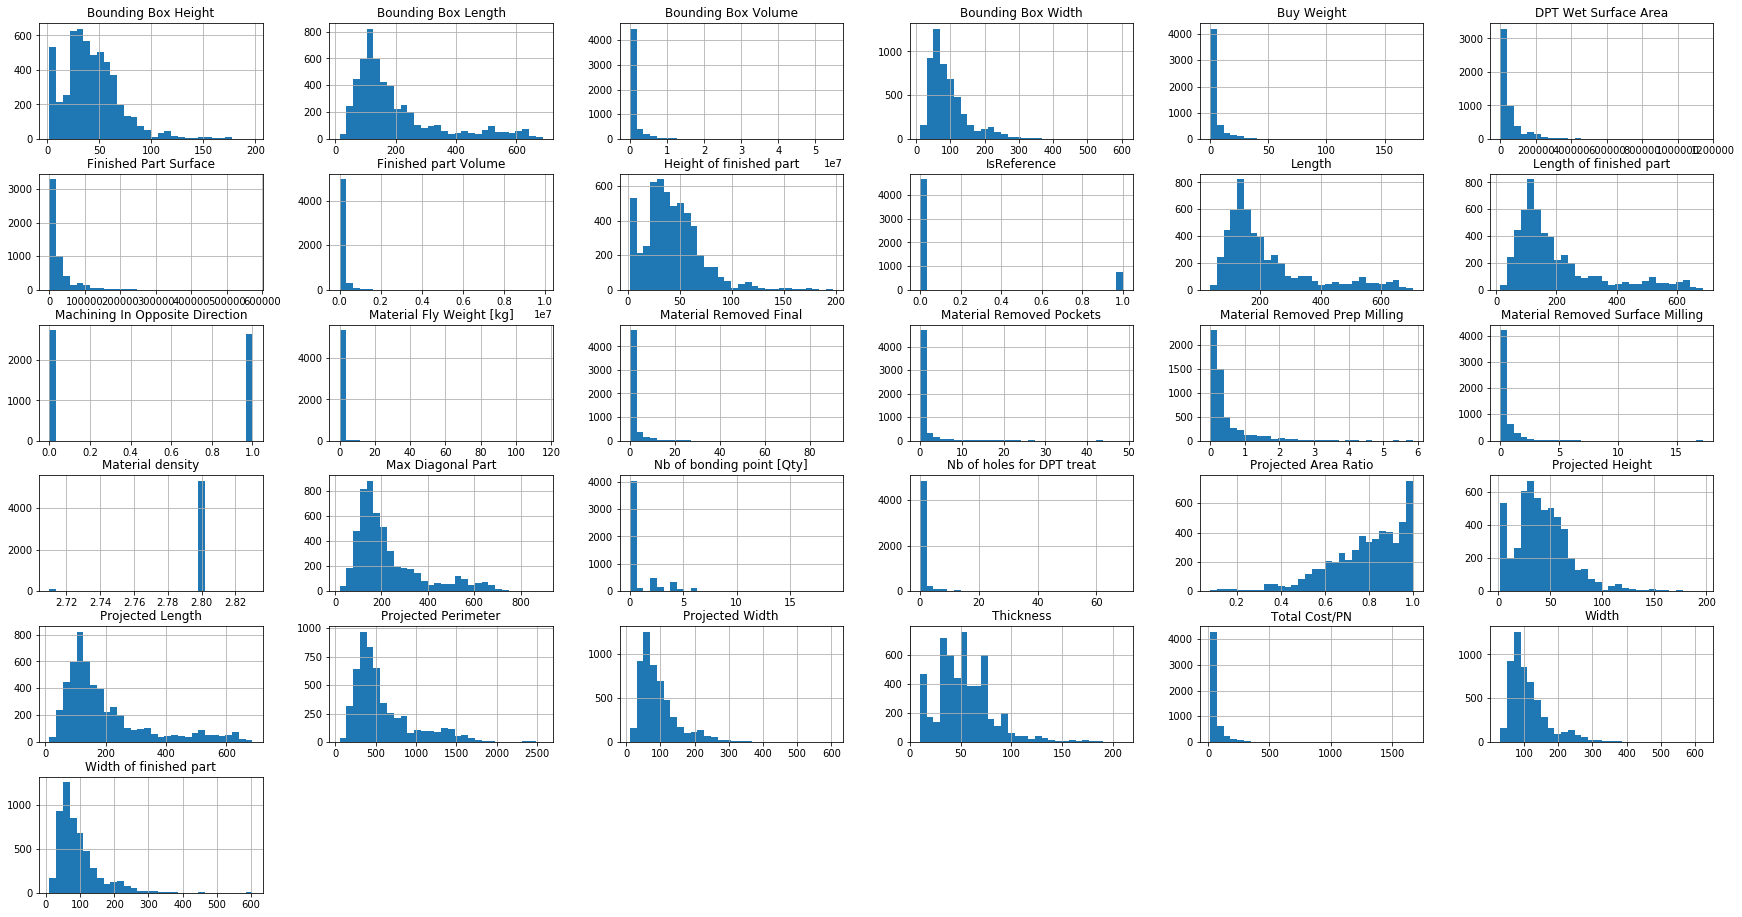

In [ ]:
numerical=[]
for col in df.columns:
  if(df[col].dtypes== 'float64'):
    numerical.append(col)

df[numerical].hist(bins=30, figsize=(30, 16), layout=(6, 6));

In [ ]:
df.shape

(5404, 37)

# **Transformation de Variables (Logarithmique)**

Comme de nombreuses variables numériques ne suivent pas réellement une distribution Gaussienne, j'ai décidé de transformer ces variables à partir de la fonction Log afin que leur distribution se rapprochent d'une Gaussienne.

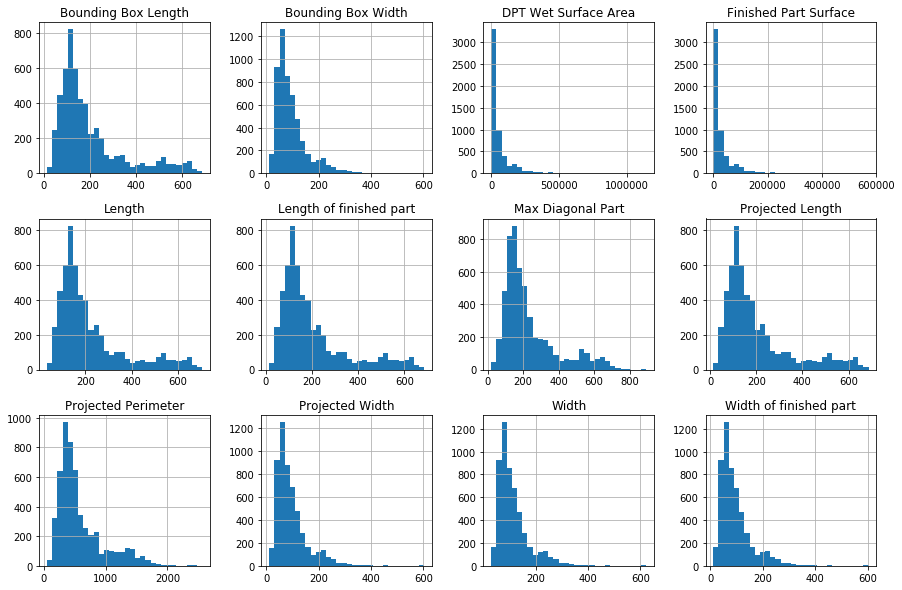

In [ ]:
log_variables=['Projected Perimeter','Projected Length', 'Bounding Box Width', 
               'Bounding Box Length', 'DPT Wet Surface Area', 'Finished Part Surface','Length', 
               'Length of finished part','Max Diagonal Part', 'Projected Width', 'Width', 'Width of finished part']
df[log_variables].hist(bins=30, figsize=(15, 10), layout=(3,4))
log_variables_names=[]
for col in df.columns:
  if(col in log_variables):
    df[col+' Log']= np.log(1+df[col])
    log_variables_names.append(col+' Log')
    df.drop(columns=col, inplace=True)

In [ ]:
df.shape

(5404, 37)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f564f7d9be0>,
      dtype=object)

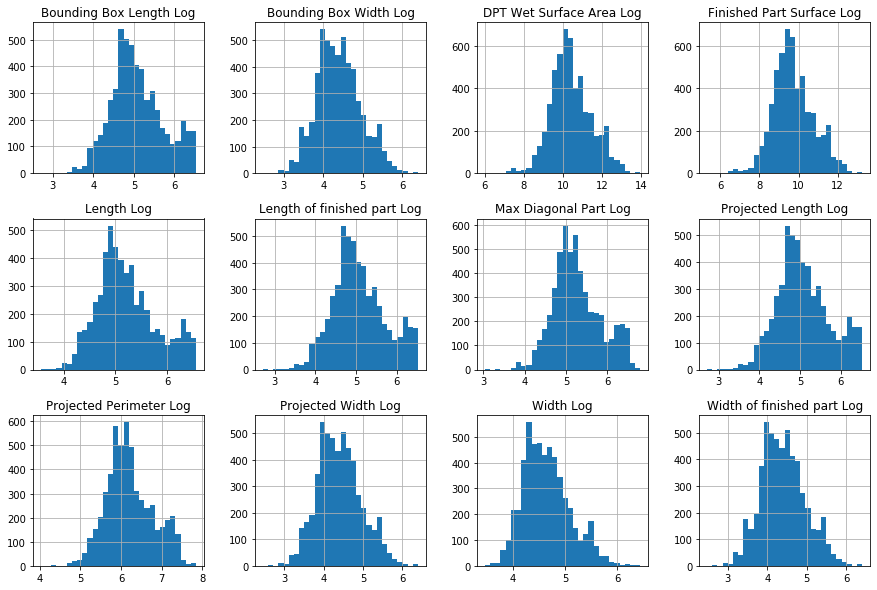

In [ ]:
df[log_variables_names].hist(bins=30,  figsize=(15, 10), layout=(3,4))

**Standard Deviation Method**



In [ ]:
#Gaussian_variables=['Bounding Box Height', 'Bounding Box Width', 'Height of finished part','Length', 'Length of finished part', 'Projected Height', 'Projected Perimeter', 'Projected Width', 'Projected Length', 'Width', 'Thickness']

Categorical_variables=[]
for col in df.columns:
  if(df[col].dtypes == 'object'):
    Categorical_variables.append(col)
Categorical_variables.append('IsReference')

No_Gaussian_variables=['Bounding Box Volume','Buy Weight', 'Finished part Volume',
                       'Machining In Opposite Direction', 'Material Fly Weight [kg]', 'Material Removed Final',
                       'Material Removed Pockets', 'Material Removed Prep Milling', 'Material Removed Surface Milling',
                       'Material density', 'Nb of bonding point [Qty]','Nb of holes for DPT treat', 'Projected Area Ratio',
                       'Total Cost/PN']
Gaussian_variables=[]
for col in df.columns:
  if((col in No_Gaussian_variables) == False and (col in Categorical_variables) == False):
    Gaussian_variables.append(col)
print('Number of Gaussian Variables: '+str(len(Gaussian_variables)))
print('Number of other Variables: '+str(len(No_Gaussian_variables)))
print('Number of Categorical Variables: '+str(len(Categorical_variables)))


df_G=pd.DataFrame({'Mean': df.loc[df[df['IsReference']==False].index ,Gaussian_variables].mean().values, 
                   'Standard Deviation': df.loc[df[df['IsReference']==False].index ,Gaussian_variables].std().values
                   },
                  index=Gaussian_variables
                 )
df_G.index.name='Variable'

df_G['lower']=round(df_G['Mean']-3*df_G['Standard Deviation'],2)
df_G['upper']=round(df_G['Mean']+3*df_G['Standard Deviation'],2)



df_G.head(5)

In [ ]:
outliers=[]
for i in range(len(Gaussian_variables)):
  
  outliers=df[((df[Gaussian_variables[i]]<df_G.iloc[i,2]) | (df[Gaussian_variables[i]]>df_G.iloc[i,3])) & (df['IsReference']==False)]
  #On filtre seulement les échantillons de l'ensemble Test
  df.drop(outliers.index, inplace=True) 
  

In [ ]:
print(df[df['IsReference']==True].shape)

(738, 37)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f564f6333c8>,
      dtype=object)

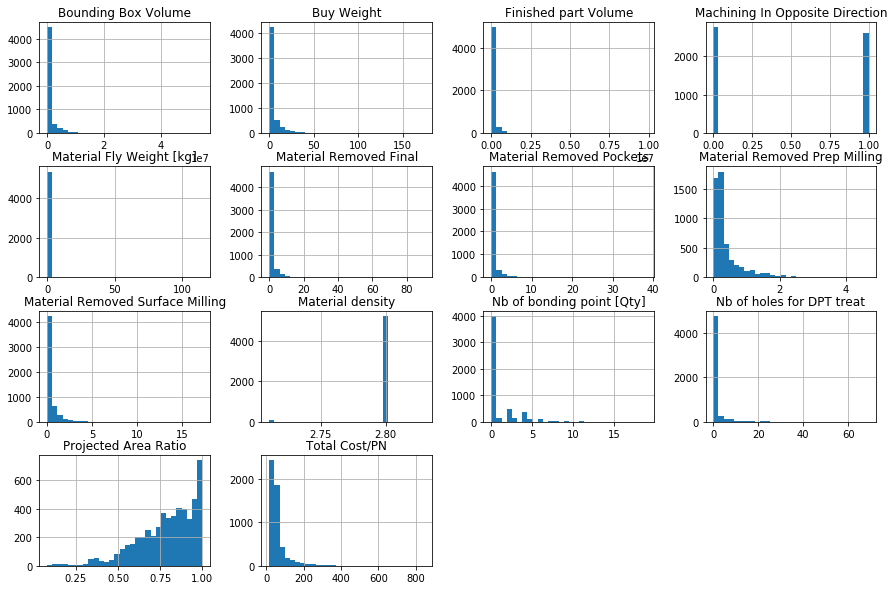

In [ ]:
df[No_Gaussian_variables].hist(bins=30, figsize=(15, 10))

**Interquartile Range Method (IQR)**

Après avoir testé cette méthode, afin de supprimer les outliers sur les variables numériques non gausiennes, j'ai observé que plus de 500 échantillons étaient supprimés de l'ensemble 'Test', ceci engendrant des performances moins bonnes qu'en les laissant.


In [ ]:
"""
df_iqr=pd.DataFrame({'Q25': df.loc[df[df['IsReference']==0].index  , No_Gaussian_variables].quantile(0.25).values, 
                   'Q75': df.loc[df[df['IsReference']==0].index  , No_Gaussian_variables].quantile(0.75).values},
                    index=No_Gaussian_variables)
df_iqr.index.name='Variable'

df_iqr["IQR"]=df_iqr['Q75']-df_iqr['Q25']
df_iqr['lower']=df_iqr['Q25']-3*df_iqr['IQR']
df_iqr['upper']=df_iqr['Q75']+3*df_iqr['IQR']

df_iqr.head(df_iqr.shape[0])
"""

'\ndf_iqr=pd.DataFrame({\'Q25\': df.loc[df[df[\'IsReference\']==0].index  , No_Gaussian_variables].quantile(0.25).values, \n                   \'Q75\': df.loc[df[df[\'IsReference\']==0].index  , No_Gaussian_variables].quantile(0.75).values},\n                    index=No_Gaussian_variables)\ndf_iqr.index.name=\'Variable\'\n\ndf_iqr["IQR"]=df_iqr[\'Q75\']-df_iqr[\'Q25\']\ndf_iqr[\'lower\']=df_iqr[\'Q25\']-3*df_iqr[\'IQR\']\ndf_iqr[\'upper\']=df_iqr[\'Q75\']+3*df_iqr[\'IQR\']\n\ndf_iqr.head(df_iqr.shape[0])\n'

In [ ]:
"""
df_3=df.copy()





for variable in No_Gaussian_variables:

  if((variable in df.columns) == False):
    print(variable)
  else:

    outliers_iqr=df[((df[variable]<df_iqr.loc[variable,'lower']) | (df[variable]>df_iqr.loc[variable,'upper'])) & (df['IsReference']==False)].index 
    df.drop(outliers_iqr, inplace=True)
"""


"\ndf_3=df.copy()\n\n\n\n\n\nfor variable in No_Gaussian_variables:\n\n  if((variable in df.columns) == False):\n    print(variable)\n  else:\n\n    outliers_iqr=df[((df[variable]<df_iqr.loc[variable,'lower']) | (df[variable]>df_iqr.loc[variable,'upper'])) & (df['IsReference']==False)].index \n    df.drop(outliers_iqr, inplace=True)\n"

### **Variables Catégorielles**

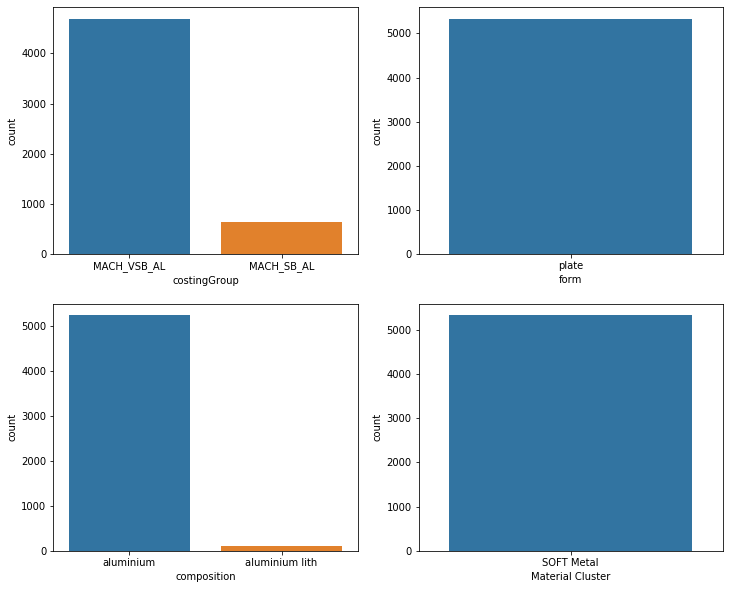

In [ ]:
categorical=[]

for col in df.columns:
  if(df[col].dtypes != 'float64' and col != 'Surface protection code (DPT)' and col != 'Designation'):
    categorical.append(col)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
i=0
for variable in Categorical_variables:
  if(variable!='Designation' and variable!='Surface protection code (DPT)' and variable!='IsReference'):
    subplot=ax.flatten()[i]
    sns.countplot(df[variable], ax=subplot)
    i+=1


On peut voir que les variables 'form' et 'Material Cluster' ne comportent qu'une seule valeur, respectivement 'plate' et 'SOFT Metal'. Ainsi, elles n'apportent pas d'information pour notre modèle, on peut donc les supprimer.

In [ ]:
df[df['costingGroup']=='MACH_SB_AL'].count()[0]

642

In [ ]:
df[df['composition']=='aluminium lith'].count()[0]

97

In [ ]:
df.drop(columns=['Material Cluster', 'form'], inplace=True)
df.shape

(5327, 35)

In [ ]:
print("Number of values for variable Designation: "+str(len(df['Designation'].unique())))
print("Number of values for variable Surface protection code (DPT): "+str(len(df['Surface protection code (DPT)'].unique())))

Number of values for variable Designation: 1278
Number of values for variable Surface protection code (DPT): 44


**Etude de la variable Designation**

In [ ]:
df.Designation.value_counts()[:7]

J'ai ici fait le choix de ne garder que les 3 premières valeurs majoritaires et de créer une valeur 'OTHER' pour le reste.

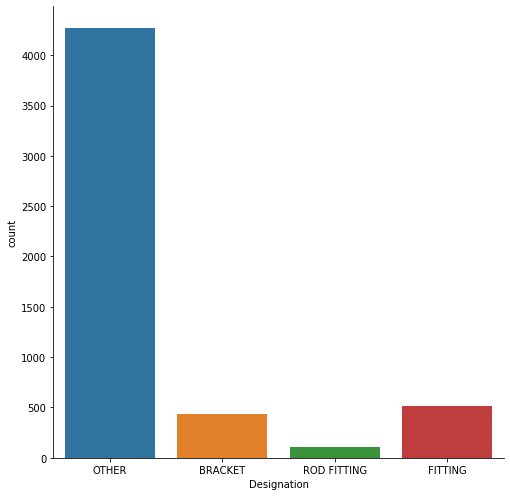

In [ ]:
def handle_designation(des):
  if(des=="FITTING" or des=="BRACKET" or des=='ROD FITTING'):
    return(des)
  else:
    return('OTHER')


df['Designation']=df['Designation'].apply(handle_designation)
sns.catplot(x='Designation', kind='count', data=df, height=7)

**Etude de la variable Surface protection code (DPT)**

In [ ]:
df['Surface protection code (DPT)'].value_counts()[:6]

AA023          4505
451             290
AA021           148
AA002+AA023      95
AA001+AA023      95
450              33
Name: Surface protection code (DPT), dtype: int64

J'ai ici fait le choix de ne garder que seulement la première valeur qui est largement majoritaire et de créer une valeur 'OTHER' pour le reste.

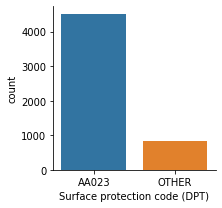

In [ ]:
def handle_DPT(dpt):
  if(dpt=="AA023"):
    return(dpt)
  else:
    return('OTHER')


df['Surface protection code (DPT)']=df['Surface protection code (DPT)'].apply(handle_DPT)
sns.catplot(x='Surface protection code (DPT)', kind='count', data=df, height=3)

In [ ]:
#Transform Categorical Variables to Ordinal Variables
def deal_categorical_variables():

  global df
  
  #Variable 'costingGroup'
  costingGroup_dummies = pd.get_dummies(df['costingGroup'], prefix='costingGroup')
  df = pd.concat([df, costingGroup_dummies], axis=1)
  df.drop('costingGroup', axis=1, inplace=True)
  
  #Variable 'composition'
  composition_dummies = pd.get_dummies(df['composition'], prefix='composition')
  df = pd.concat([df, composition_dummies], axis=1)
  df.drop('composition', axis=1, inplace=True)
  
  #Variable 'Designation'
  Designation_dummies = pd.get_dummies(df['Designation'], prefix='Designation')
  df = pd.concat([df, Designation_dummies], axis=1)
  df.drop('Designation', axis=1, inplace=True)

  #Variable 'Surface protection code (DPT)'
  DPT_dummies = pd.get_dummies(df['Surface protection code (DPT)'], prefix='Surface protection code (DPT)')
  df = pd.concat([df, DPT_dummies], axis=1)
  df.drop('Surface protection code (DPT)', axis=1, inplace=True)

  return df

df=deal_categorical_variables()
df.head(5)

In [ ]:
df.shape

(5327, 41)

### **Normalisation des Variables**

In [ ]:
#Mélange des données
df=df.sample(frac=1)

#On sépare l'ensemble de Références, utilisé ici pour le test lors de la Méthode n°1.
df_train=df[df['IsReference']==False]
df_test=df[df['IsReference']==True]

scaler = StandardScaler()
X_train=scaler.fit_transform(df_train.drop(columns=['Total Cost/PN']))
#y=scaler.fit_transform(np.asarray(df['Total Cost']).reshape(-1,1))
y_train=df_train['Total Cost/PN']
print("X Shape: "+str(X_train.shape))
print("y Shape: "+str(y_train.shape))
#y_train.describe()


X Shape: (4589, 40)
y Shape: (4589,)


In [ ]:
X_test=scaler.fit_transform(df_test.drop(columns=['Total Cost/PN']))
y_test=df_test['Total Cost/PN']
print("X Test Shape: "+str(X_test.shape))
print("y Test Shape: "+str(y_test.shape))

X Test Shape: (738, 40)
y Test Shape: (738,)


## **Modèles de Machine Learning**

In [ ]:
def compute_score(clf, X=X_train, y=y_train):
    mse_xval = cross_val_score(clf, X, y, cv = 5, scoring='neg_mean_squared_error')
    mae_xval = cross_val_score(clf, X, y, cv = 5, scoring='neg_mean_absolute_error')
    r2_xval = cross_val_score(clf, X, y, cv = 5, scoring='r2')

    results=[-np.mean(mae_xval),
             np.sqrt(-np.mean(mse_xval)),
             np.mean(r2_xval)]
    print('Mean Absolute Error: %.2f'% results[0]) 
    print('Root Mean Squared Error: %.2f'% results[1])
    print('R2 score: %.2f' % results[2])
    return results

In [ ]:
def plot_curves(estimator, X=X_train, y=y_train, cv=5,scoring='neg_mean_absolute_error' ):

  train_sizes, train_scores, valid_scores=learning_curve(estimator, X=X_train, y=y_train, cv=5, scoring=scoring)
  train_scores_std = np.std(train_scores, axis=1)
  train_scores=np.mean(-train_scores, axis=1)
  valid_scores_std = np.std(valid_scores, axis=1)
  valid_scores=np.mean(-valid_scores, axis=1)
  

  plt.figure()
  plt.grid()
  plt.plot(train_sizes, train_scores,'o-', color='r', label='Training Score')
  plt.fill_between(train_sizes, train_scores - train_scores_std,train_scores + train_scores_std, alpha=0.1,color="r")
  plt.plot(train_sizes, valid_scores,'o-', color='g', label='Cross-Validation Score')
  plt.fill_between(train_sizes, valid_scores - valid_scores_std,valid_scores + valid_scores_std, alpha=0.1,color="g")


  plt.title("Learning Curve")
  plt.xlabel("Training Set Size" )
  plt.ylabel("Mean Absolute Error")
  plt.legend(loc="best")
  plt.show()  

# **Méthode n°1: Entrainement sur les données intitulées Test et test sur les données de références**

## **Régression Linéaire**

In [ ]:
LinR=LinearRegression()
#Entrainement du modèle
LinR.fit(X_train, y_train)
#Evaluation du modèle
scores_linr=compute_score(LinR)


Mean Absolute Error: 3.70
Root Mean Squared Error: 7.39
R2 score: 0.97


In [ ]:
#plot_curves(LinearRegression())

# **S.V.M.**

In [ ]:
svm = SVR(gamma= 'auto') 
#Entrainement du modèle
svm.fit(X_train, y_train)
#Obtention des scores
scores_svm=compute_score(svm)

Mean Absolute Error: 8.03
Root Mean Squared Error: 28.85
R2 score: 0.61


In [ ]:
#plot_curves(SVR(gamma= 'auto'))

# **Random Forest**

In [ ]:
rf = RandomForestRegressor(n_estimators=50, max_features='sqrt' , criterion= 'mse', max_depth=30, random_state=42) 
#Entrainement du modèle
rf.fit(X_train, y_train)
#Obtention des scores
scores_rf=compute_score(rf)

Mean Absolute Error: 1.82
Root Mean Squared Error: 3.72
R2 score: 0.99


In [ ]:
#plot_curves(RandomForestRegressor(n_estimators=50, max_features='sqrt' , criterion= 'mse', max_depth=30, random_state=42) )

# **Neural Network**

In [ ]:
mlp=MLPRegressor(hidden_layer_sizes=(42,32,22,12,),
                                       activation='tanh',
                                       solver='adam',
                                       batch_size=int(0.05*X_train.shape[0]),
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.01,
                                       alpha=0.01)
#Entrainement du modèle
mlp.fit(X_train, y_train)
scores_mlp=compute_score(mlp)

Mean Absolute Error: 4.75
Root Mean Squared Error: 11.22
R2 score: 0.94


# **GradientBoosting**

In [ ]:
"""
Gb = GradientBoostingRegressor(loss='ls', n_estimators=80)
Gb.fit(X_train, y_train)
scores_Gb=compute_score(Gb)
"""

"\nGb = GradientBoostingRegressor(loss='ls', n_estimators=80)\nGb.fit(X_train, y_train)\nscores_Gb=compute_score(Gb)\n"

In [ ]:
#plot_curves(GradientBoostingRegressor(loss='ls', n_estimators=80))

# **XGBoost**

In [ ]:
"""
XGb = XGBRegressor()
XGb.fit(X_train, y_train)
scores_XGb=compute_score(XGb)
"""

'\nXGb = XGBRegressor()\nXGb.fit(X_train, y_train)\nscores_XGb=compute_score(XGb)\n'

# **Grid Search**

In [ ]:
# turn run_gs to True if you want to run the gridsearch again.
def run_GS(model='Gb', run_gs=False, parameters={}, X_train=X_train, y_train=y_train):

  if run_gs:

    if(model=='Gb'):
      parameter_grid = {'loss': ['ls'],
                        'learning_rate': [0.1],
                        'n_estimators': [400, 600, 800]
                        }
      regressor = GradientBoostingRegressor()
    
    #XGBoost
    elif(model=='XGb'):
    
      parameter_grid = {'booster' : ['gbtree', 'gblinear', 'dart'],
                        'eta' : [0.2, 0.3, 0.4],
                        'max_depth': [3, 6, 10]
                      } 
    
    
      regressor = XGBRegressor()
    


    cross_validation = KFold(n_splits=5)

    grid_search = GridSearchCV(regressor,
                                scoring='neg_mean_squared_error',
                                param_grid=parameter_grid,
                                cv=cross_validation,
                                verbose=1
                                )
    grid_search.fit(X_train, y_train)

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    return(grid_search.best_params_)
      
  else: 
    if(model=='Gb'):
      regressor = GradientBoostingRegressor(**parameters)
    elif(model=='XGb'):
      regressor = XGBRegressor(**parameters)

    regressor.fit(X_train, y_train)
    scores=compute_score(regressor)
    return(scores)

In [ ]:
#XGb_parameters=run_GS(model='XGb', run_gs=True)
XGb_parameters={'booster': 'gbtree', 'eta': 0.2, 'max_depth': 10, 'objective' :'reg:squarederror'}

In [ ]:
XGb_GS=XGBRegressor(**XGb_parameters)
XGb_GS.fit(X_train, y_train)
scores_XGb_GS = compute_score(XGb_GS)

Mean Absolute Error: 1.32
Root Mean Squared Error: 2.80
R2 score: 1.00


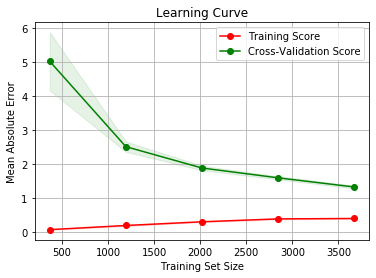

In [ ]:
plot_curves(XGBRegressor(**XGb_parameters), cv=5)

In [ ]:
#Gb_parameters=run_GS(model='Gb', run_gs=True)
Gb_parameters={'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 800}

In [ ]:
Gb_GS=GradientBoostingRegressor(**Gb_parameters)
Gb_GS.fit(X_train, y_train)
scores_Gb_GS = compute_score(Gb_GS)

Mean Absolute Error: 1.73
Root Mean Squared Error: 3.04
R2 score: 1.00


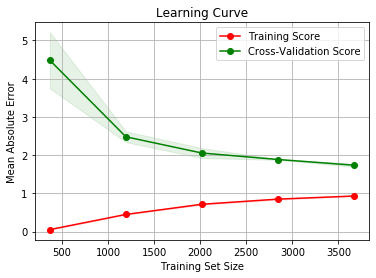

In [ ]:
plot_curves(GradientBoostingRegressor(**Gb_parameters))

## **Modèle Ensembliste**

In [ ]:
from sklearn.ensemble import VotingRegressor

xgb_ens=XGBRegressor(**XGb_parameters)
gb_ens= GradientBoostingRegressor(**Gb_parameters)
#linr_ens=LinearRegression()

estimators=[]
estimators.append(('XGBoost', xgb_ens))
estimators.append(('Gradient Boosting', gb_ens))

ensemble = VotingRegressor(estimators)
ensemble.fit(X_train, y_train)
scores_ens= compute_score(ensemble)

Mean Absolute Error: 1.45
Root Mean Squared Error: 2.74
R2 score: 1.00


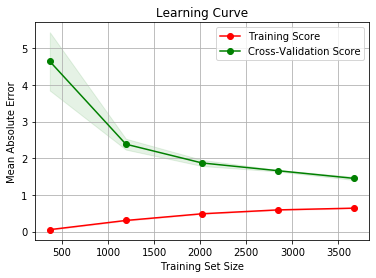

In [ ]:
plot_curves(VotingRegressor(estimators))

# **Ranking des modèles de Machine Learning**


In [ ]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Support Vector Machine', 'Random Forest','Gradient Boosting GS'  , 'XG Boost GS', '(XGB_GS+ GB_GS)'],
    'R2 score':  [scores_linr[2], scores_svm[2], scores_rf[2], scores_Gb_GS[2], scores_XGb_GS[2], scores_ens[2]],
    'RMSE score': [scores_linr[1], scores_svm[1], scores_rf[1], scores_Gb_GS[1],  scores_XGb_GS[1], scores_ens[1]],
    'MAE score': [scores_linr[0], scores_svm[0], scores_rf[0], scores_Gb_GS[0], scores_XGb_GS[0], scores_ens[0]],

    })
models.sort_values(by='R2 score', ascending=False)

,Model,R2 score,RMSE score,MAE score
5,(XGB_GS+ GB_GS),0.996295,2.739077,1.448299
4,XG Boost GS,0.996118,2.800439,1.323523
3,Gradient Boosting GS,0.995520,3.036227,1.725283
2,Random Forest,0.993398,3.716358,1.823664
0,Linear Regression,0.973891,7.386096,3.700434
1,Support Vector Machine,0.605025,28.854490,8.028324


# **Performances du modèle sur l'ensemble de références**

In [ ]:
def evaluate(clf, X_test=X_test, y_test=y_test):

  y_predict=clf.predict(X_test)

  score_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
  score_MAE = metrics.mean_absolute_error(y_test, y_predict)
  #score_R2 = metrics.r2_score(y_test, y_predict)

  df_res=pd.DataFrame({'RMSE Score': [score_RMSE],
                       'MAE Score': [score_MAE],
                       'Coût Moyen': [y_test.mean()],
                       'Erreur Relative Moyenne': [score_MAE/(y_test.mean())],
                       },
                      index=['Ensemble (Gb_GS + XGb_GS)'])
  return(df_res)


res=evaluate(ensemble)
res.head()


,RMSE Score,MAE Score,Coût Moyen,Erreur Relative Moyenne
Ensemble (Gb_GS + XGb_GS),39.550469,19.173972,74.812267,0.256294


# **Méthode n°2: Entrainement d'un modèle sur les références puis test sur le fichier Test**

In [ ]:
ensemble = VotingRegressor(estimators)
ensemble.fit(X_test, y_test)

scores_ref_ens= compute_score(ensemble, X=X_test, y=y_test)

Mean Absolute Error: 3.80
Root Mean Squared Error: 17.10
R2 score: 0.95


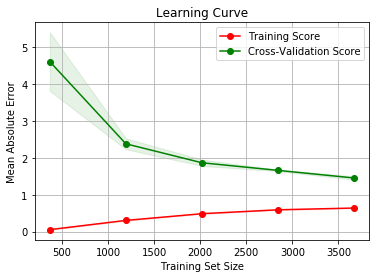

In [ ]:
plot_curves(ensemble, X=X_test, y=y_test)

# **Performances du modèle sur l'ensemble de Test**

In [ ]:
evaluate(ensemble, X_test=X_train, y_test=y_train)

,RMSE Score,MAE Score,Coût Moyen,Erreur Relative Moyenne
Ensemble (Gb_GS + XGb_GS),36.767052,19.667037,58.93441,0.333711
